# Title

## 1 The Business Analytical Question

In this notebook, the AirBnb summary data for New York is explored, transformed and analysed in order to answer the question, "what factors influence whether or not a listing is reviewed?". **This question was chosen because....**

### Frame the problem

How will Airbnb benefit from the model?

If we can ascertain the features that contribute to the "success" of a listing (represented by whether or not it receives reviews), we can direct marketing energy towards potential hosts who are more likely to succeed.

### Previous attempts at the problem



## 2.1 Exploratory Data Analysis (EDA)

First, the required libraries and data are imported.

In [1]:
# import libraries

import math, csv

from typing import List, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report, plot_confusion_matrix, make_scorer

from xgboost import XGBClassifier, plot_importance
import xgboost as xgb
import shap


In [2]:
airbnb = pd.read_csv('data/AB_NYC_2019.csv')

airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
num_listings = len(airbnb)
num_hosts = len(airbnb['host_id'].unique())

print(f'The data contains information about {num_listings} AirBnB listings from {num_hosts} hosts')

The data contains information about 48895 AirBnB listings from 37457 hosts


### 2.1.1 Missing values

In [4]:
# check for missing values

airbnb.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Some of these columns are irrelevant to the number of reviews being posted. For example, there's no mechanism by which id, host_name, and host_id could impact the number of reviews. The IDs are identifiers used to track the listings in other data sets (for example, AirBnb likely has data sets of reviews and host details). 

There may be information within the 'name' column that could influence the presence of reviews - for example, the name may list amenities such as a hot tub or garden that would make the listing more likely to be booked and then reviewed. However, this is beyond the scope of this project, so the name column will be removed from the dataset.

Therefore we can safely drop the columns `id`, `name`, `host_id`, and `host_name`, which will in turn address the missing values in `name` and `host_name`.

In [5]:
airbnb = airbnb.drop(['id', 'name', 'host_id', 'host_name'], axis = 1)
airbnb.isna().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Let's investigate these missing values for `last review` and `reviews_per_month`

In [6]:
airbnb[airbnb['last_review'].isna()]['number_of_reviews'].value_counts()

0    10052
Name: number_of_reviews, dtype: int64

In [7]:
airbnb[airbnb['reviews_per_month'].isna()]['number_of_reviews'].value_counts()

0    10052
Name: number_of_reviews, dtype: int64

In [8]:
len(airbnb[airbnb['number_of_reviews']==0])

10052

The missing values correspond to rows where there are no reviews. In these cases there is no date of last review because there have been no reviews, and `reviews_per_month` cannot be calculated.

Therefore we can fill the missing values with 0. It won't make a difference, however, as `reviews_per_month` and `last_review` are so strongly correlated with `number of reviews` that we will not be using them as features in the model.

In [9]:
airbnb.fillna(0, inplace = True)
airbnb.isna().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [10]:
airbnb.drop(columns = ['last_review', 'reviews_per_month'], inplace = True)
airbnb.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


### 2.1.2 Split training and test data

At this point we should separate our training data from our test data. We will note all of the steps we perform on the training data and repeat them on the test data. This prevents information leakage from the test set **(CITE)**.


In [11]:
airbnb, final_test_set = train_test_split(airbnb, random_state = 42, test_size = 0.1)

# Because we will be testing downsampling and outlier removal techniques we will need as large a training set as possible
raw_train, raw_test = train_test_split(airbnb, random_state = 42, test_size = 0.1)
raw_train.head()

print(len(airbnb))
print(len(raw_train))
print(len(raw_test))
print(len(final_test_set))

44005
39604
4401
4890


### 2.1.3 Encode the Target Variable

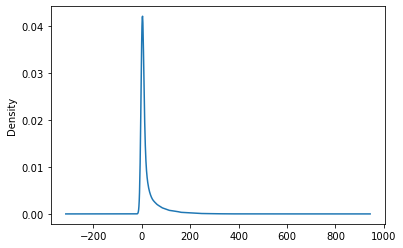

In [12]:
airbnb['number_of_reviews'].plot(kind = 'density');

Because we are looking to target listings that have received no reviews, it makes more sense to covert the number of reviews into binary classes (1 for 'has reviews' and 0 for 'does not have reviews')

In [13]:
# Encode target variable as 0 (no reviews) or 1 (reviews)

def encode_target(df: pd.DataFrame) -> pd.DataFrame:
    feature_col = 'number_of_reviews'
    new_df = df.copy()
    new_df['has_reviews'] = df[feature_col].apply(lambda r: 0 if r == 0 else 1)
    return new_df.drop(columns = [feature_col])

raw_train = encode_target(raw_train)
raw_test = encode_target(raw_test)

In [14]:
"""
Make a copy of the training data to explore during EDA. 
We can try transformations on this dataset to see if they improve the distributions. 
If they work, apply them to the training and test sets.
"""
eda_data = raw_train.copy()

### 2.1.4 EDA

Next, examine the distribution of numeric features.

In [15]:
### Numerical attributes

numerical_data = eda_data.select_dtypes('number')
#sns.pairplot(numerical_data);

**comment on this**

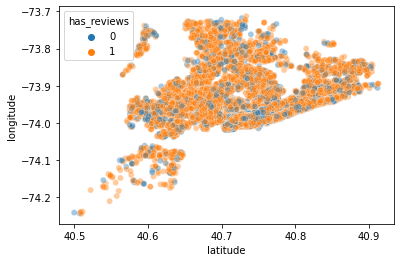

In [16]:
sns.scatterplot(data = eda_data, x = 'latitude', y = 'longitude', hue = 'has_reviews', alpha = 0.4);

In [17]:
def plot_distribution(df, col_of_interest, title = None, color_split = 'has_reviews'):
    if title == None:
        title = "Distribution of "+ col_of_interest.replace('_', ' ') + " of AirBnB listings in New York City"
    fig, ax = plt.subplots(figsize = (10,8))
    ax.set_title(title)
    df[df[color_split]==1][col_of_interest].plot(kind = 'density', ax = ax, label = 'has reviews')
    df[df[color_split]==0][col_of_interest].plot(kind = 'density', ax = ax, label = 'does not have reviews')
    ax.plot(df[col_of_interest], [-0.0001]*len(df[col_of_interest]), '|', color='k')
    ax.legend();
    return ax

<AxesSubplot:title={'center':'Distribution of latitude of AirBnB listings in New York City'}, ylabel='Density'>

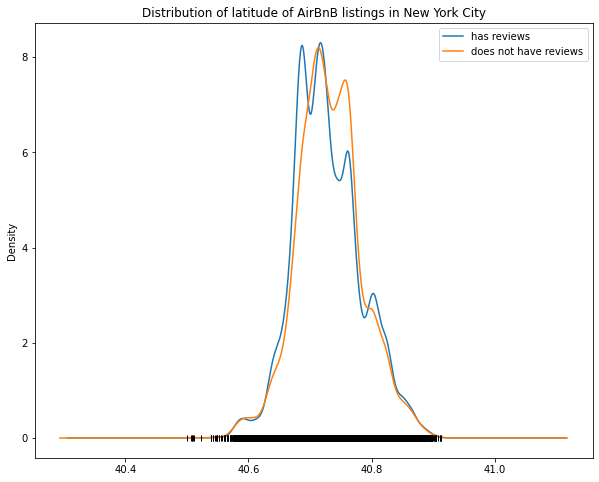

In [18]:
plot_distribution(eda_data, 'latitude')

<AxesSubplot:title={'center':'Distribution of longitude of AirBnB listings in New York City'}, ylabel='Density'>

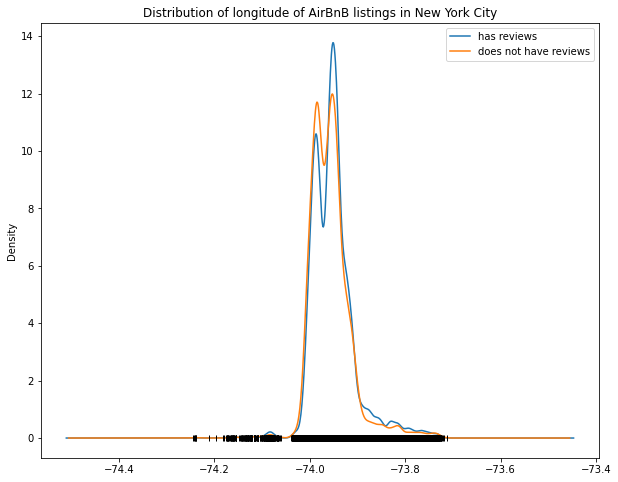

In [19]:
plot_distribution(eda_data, 'longitude')

<AxesSubplot:title={'center':'Distribution of price of AirBnB listings in New York City'}, ylabel='Density'>

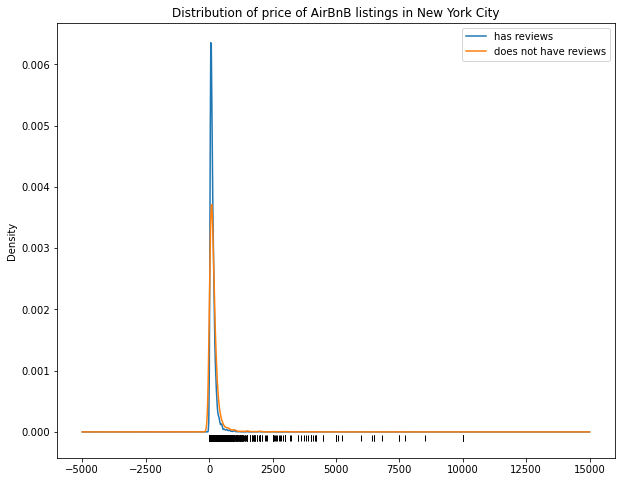

In [20]:
plot_distribution(eda_data, 'price')

The price distribution looks like it might be log normal. Transform it to get a normally distributed variable.

<AxesSubplot:title={'center':'Distribution of log price of AirBnB listings in New York City'}, ylabel='Density'>

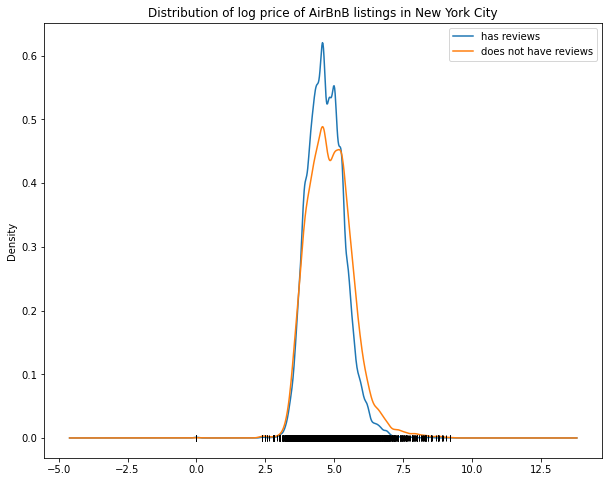

In [21]:
eda_data['log_price'] = eda_data['price'].apply(lambda p: np.log(p+1))
plot_distribution(eda_data, 'log_price')

The natural logarithm of price is approximately normally distributed.

<AxesSubplot:title={'center':'Distribution of availability of AirBnB listings (days out of 365)'}, ylabel='Density'>

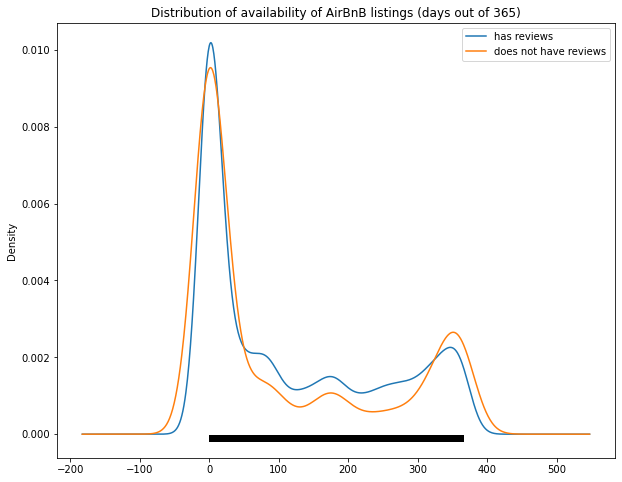

In [22]:
plot_distribution(eda_data, 'availability_365', title = 'Distribution of availability of AirBnB listings (days out of 365)')

It seems that a high proportion of listings are not actually available (availability = 0). These listings will be examined more closely. If they are not available now, have they ever been available? If any of them have reviews, it would imply that they have been available in the past.

In [23]:
eda_data[eda_data['availability_365']==0][['availability_365', 'has_reviews']].groupby(['has_reviews']).count()

,availability_365
has_reviews,
0,3948
1,10225


Many of the listings that are unavailable still have reviews. This suggests that at the time of the review(s), their availability was greater than 0. Going forward, we should bear in mind that the availability of the listings changes over time and we only have access to the value of availability at a single point in time. This might make the `availability_365` feature unreliable.

Make the data continuous by converting to the fraction of the year when the listing is available.

<AxesSubplot:title={'center':'Distribution of availability frac of AirBnB listings in New York City'}, ylabel='Density'>

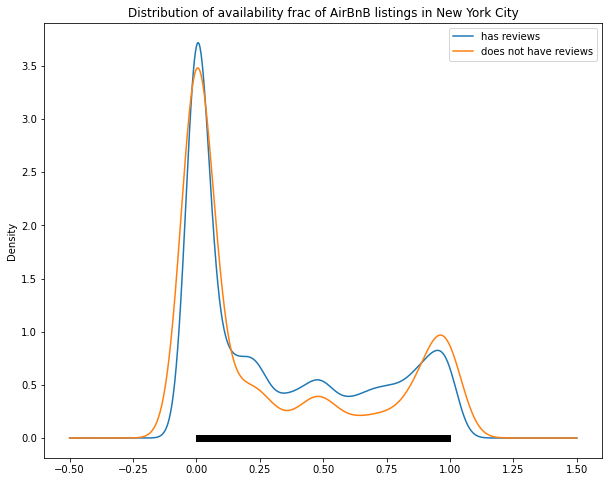

In [24]:
eda_data['availability_frac'] = eda_data['availability_365'] / 365
plot_distribution(eda_data, 'availability_frac')

<AxesSubplot:title={'center':'Distribution of calculated host listings count of AirBnB listings in New York City'}, ylabel='Density'>

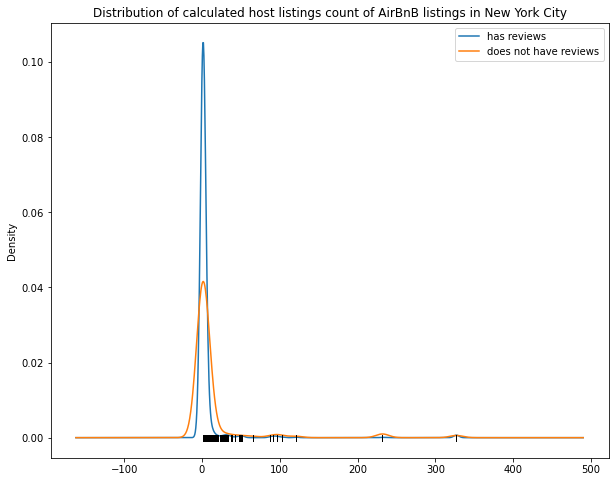

In [25]:
plot_distribution(eda_data, 'calculated_host_listings_count')

Again, this looks like a log normal distribution with some very large outliers.

<AxesSubplot:title={'center':'Distribution of log calculated host listings count of AirBnB listings in New York City'}, ylabel='Density'>

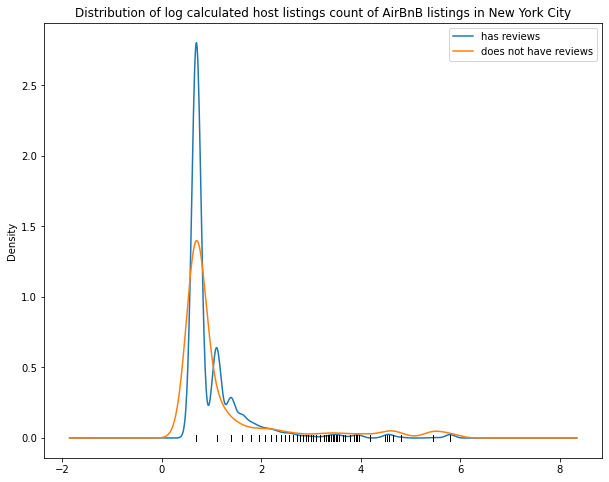

In [26]:
# since we are now performing log twice we should create a function that we will apply to the test and training data.
def transform_log_normal_variables(df: pd.DataFrame, columns_to_transform: List[str], drop = True) -> pd.DataFrame:
    new_df = df.copy()
    for col in columns_to_transform:
        new_column = 'log_' + col
        new_df[new_column] = new_df[col].apply(lambda x: np.log(x+1)) # prevent ln 0 errors
    if drop:
        new_df.drop(columns = columns_to_transform, inplace = True)
    return new_df

eda_data = transform_log_normal_variables(eda_data, ['calculated_host_listings_count'], drop = False)
plot_distribution(eda_data, 'log_calculated_host_listings_count')

On inspection it does not appear to be a log normal distribution. The data is bounded by 0 and has a long tail in the positive direction.

In [27]:
eda_data.drop(columns= ['log_calculated_host_listings_count'], inplace = True)

<AxesSubplot:title={'center':'Distribution of minimum nights of AirBnB listings in New York City'}, ylabel='Density'>

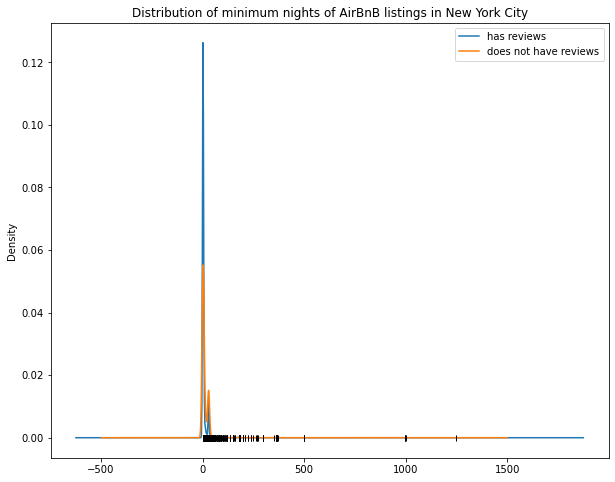

In [28]:
plot_distribution(eda_data, 'minimum_nights')

This variable also has some extreme outliers.

Minimum nights greater than a few month lean more towards tenancy than holiday stay.

We will create an OutlierRemover than can be used to strip outliers from the training data to see if it improves model performance. For visualisation purposes the outliers will be removed.

<AxesSubplot:title={'center':'Distribution of availability 365 of AirBnB listings in New York City'}, ylabel='Density'>

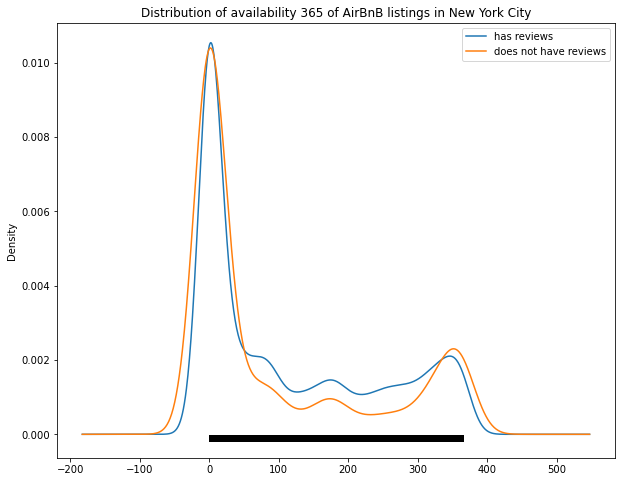

In [29]:
class OutlierRemover:
    def __init__(self, min_z_score = -3, max_z_score = 3):
        self.min_z_score = min_z_score
        self.max_z_score = max_z_score
        self.means_sds = {}
        self.list_of_columns = []
    def fit(self, data, list_of_columns = []):
        if len(list_of_columns)==0:
            list_of_columns = data.columns
        self.list_of_columns = list_of_columns
        for col in list_of_columns:
            mean = data[col].mean()
            sd = np.sqrt(data[col].var())
            self.means_sds[col] = (mean, sd)
    def calculate_z_score(self, value, col):
        return (value - self.means_sds[col][0])/self.means_sds[col][1]
    def transform(self, data):
        if len(self.means_sds.keys())==0:
            print("Transformer must be fit before transformation. Call .fit(data) or .fit_transform(data)")
            return
        for col in self.list_of_columns:
            z_scores = data[col].apply(self.calculate_z_score, col=col)
            keep = (z_scores>self.min_z_score)&(z_scores<self.max_z_score)
            data = data[keep]
        return data
    def fit_transform(self, data, list_of_cols = []):
        self.fit(data, list_of_cols)
        return self.transform(data)

o_r = OutlierRemover()

numerical_features = eda_data.select_dtypes('number')
eda_data[numerical_features.columns] = o_r.fit_transform(numerical_features)
plot_distribution(eda_data, 'availability_365')

<AxesSubplot:title={'center':'Distribution of minimum nights of AirBnB listings in New York City'}, ylabel='Density'>

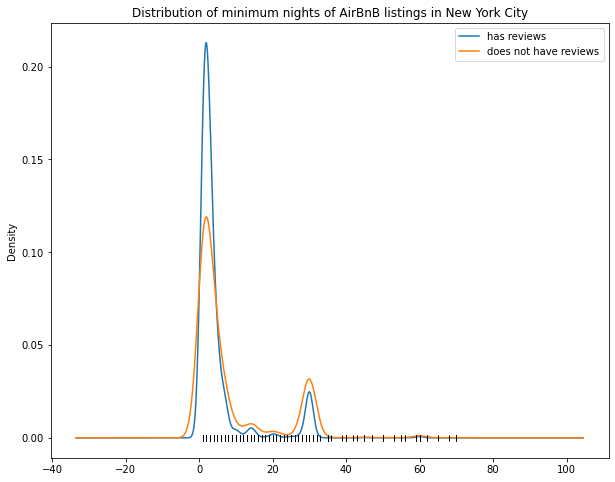

In [30]:
plot_distribution(eda_data, 'minimum_nights')

### Categorical features

In [31]:
eda_data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews,log_price,availability_frac
3432,Manhattan,East Village,40.72829,-73.98907,Private room,69.0,13.0,1.0,84.0,1.0,4.248495,0.230137
4332,Brooklyn,Prospect Heights,40.68183,-73.97195,Entire home/apt,450.0,30.0,1.0,0.0,0.0,6.111467,0.000000
39499,Manhattan,Midtown,40.74841,-73.98768,Entire home/apt,220.0,2.0,13.0,286.0,1.0,5.398163,0.783562
42968,Brooklyn,Bedford-Stuyvesant,40.69647,-73.94248,Private room,70.0,5.0,1.0,37.0,0.0,4.262680,0.101370
42489,Brooklyn,Brighton Beach,40.57974,-73.95892,Private room,55.0,1.0,1.0,0.0,1.0,4.025352,0.000000


<AxesSubplot:xlabel='room_type', ylabel='log_price'>

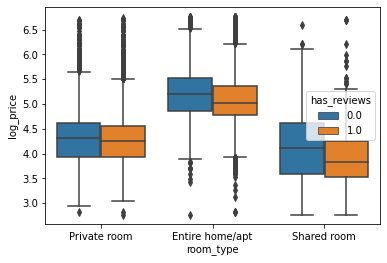

In [32]:
sns.boxplot(data = eda_data, x = 'room_type', y = 'log_price', hue = 'has_reviews')

In [33]:
eda_data['neighbourhood_group'].unique()

array(['Manhattan', 'Brooklyn', 'Bronx', 'Queens', 'Staten Island'],
      dtype=object)

<AxesSubplot:xlabel='neighbourhood_group', ylabel='log_price'>

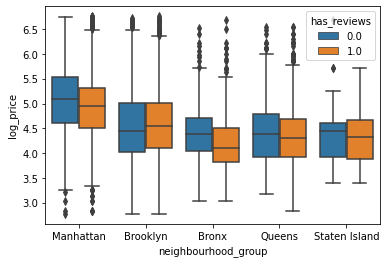

In [34]:
sns.boxplot(data = eda_data, x = 'neighbourhood_group', y = 'log_price', hue = 'has_reviews')

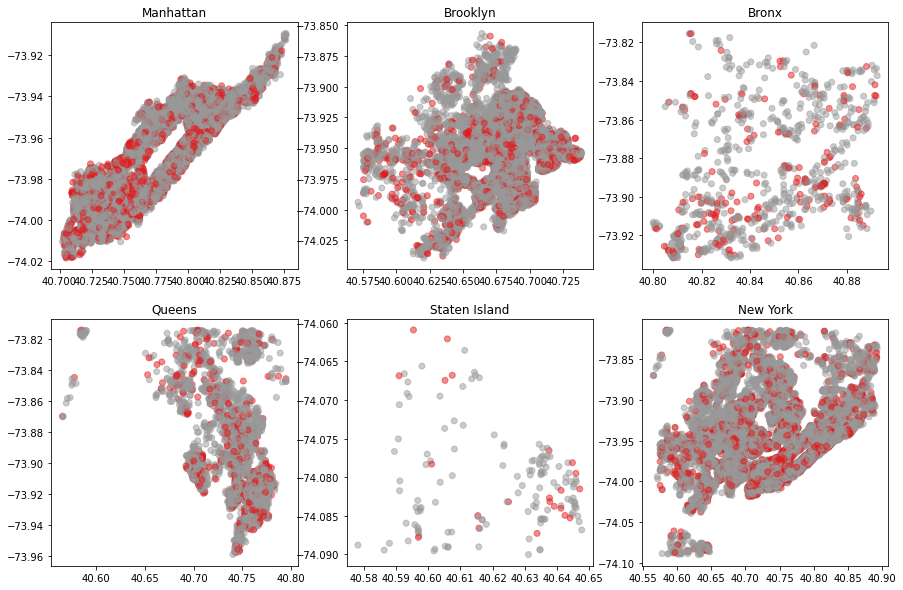

In [35]:
fig, axs = plt.subplots(ncols = 3, nrows =2, figsize = (15,10))

neighs = eda_data['neighbourhood_group'].unique().tolist() + ['New York']
i = 0

for row in range(2):
    for col in range(3):
        if i < 5:
            neigh_dat = eda_data[eda_data['neighbourhood_group']==neighs[i]]
        else:
            neigh_dat = eda_data
        axs[row, col].scatter(x = neigh_dat['latitude'], y = neigh_dat['longitude'], 
                              c = neigh_dat['has_reviews'], alpha = 0.5, cmap = 'Set1')
        axs[row, col].set_title(neighs[i])
        i+=1

It doesn't appear that location has an impact on whether or not a listing has reviews - there is a mixture of both in each neighbourhood and fairly well distributed.

The latitude and longitude will be included anyway, to see if there is a relationship influenced by another factor.

Even though one could argue that entire home is "better" than private room, assigning the room types values 1, 2, and 3 would assume that they are equally spaced. These  values will be one hot encoded instead.
For now, neighbourhood and neighbourhood group will **not** be used - the assumption is that the information about vicinity is adequately encoded by latitude and longitude. They can be brought back in later if needed.



In [36]:
ohe = OneHotEncoder()

def adjust_column_headers(col: str):
    return col.lower().replace(' ', '_')

def one_hot_encode(df, col_to_encode, ohe: OneHotEncoder, fit = True, col_to_drop = None) -> pd.DataFrame:
    data_to_encode = df[[col_to_encode]]
    if fit:
        ohe_data_array = ohe.fit_transform(data_to_encode).toarray()
    else:
        ohe_data_array = ohe.transform(data_to_encode).toarray()
    column_names = ohe.get_feature_names([col_to_encode])
    column_names = [adjust_column_headers(col) for col in column_names]
    col_to_drop = col_to_encode + '_' + adjust_column_headers(col_to_drop)
    ohe_data = pd.DataFrame(data = ohe_data_array, columns = column_names)
    if col_to_drop is None:
        cols_to_drop = [col_to_encode]
    else:
        cols_to_drop = [col_to_encode, col_to_drop]
    new_df = pd.concat([df.reset_index(drop = True), ohe_data], axis = 1).drop(columns = cols_to_drop)
    return new_df
    
eda_data = one_hot_encode(eda_data, 'room_type', ohe, col_to_drop = 'Shared room')
eda_data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews,log_price,availability_frac,room_type_entire_home/apt,room_type_private_room
0,Manhattan,East Village,40.72829,-73.98907,69.0,13.0,1.0,84.0,1.0,4.248495,0.230137,0.0,1.0
1,Brooklyn,Prospect Heights,40.68183,-73.97195,450.0,30.0,1.0,0.0,0.0,6.111467,0.000000,1.0,0.0
2,Manhattan,Midtown,40.74841,-73.98768,220.0,2.0,13.0,286.0,1.0,5.398163,0.783562,1.0,0.0
3,Brooklyn,Bedford-Stuyvesant,40.69647,-73.94248,70.0,5.0,1.0,37.0,0.0,4.262680,0.101370,0.0,1.0
4,Brooklyn,Brighton Beach,40.57974,-73.95892,55.0,1.0,1.0,0.0,1.0,4.025352,0.000000,0.0,1.0


Before attempting to visualise two or three variables together, the data will be scaled.

In [37]:
def scale_data(df: pd.DataFrame, columns_to_transform: List[str], scaler, fit = True, drop = True) -> pd.DataFrame:
    data_to_transform = df.copy()[columns_to_transform]
    scaled_data = scaler.fit_transform(data_to_transform)
    new_cols = ['scaled_' + col for col in columns_to_transform]
    df[new_cols] = scaled_data
    if drop:
        df.drop(columns=columns_to_transform, inplace = True)
    return df

eda_data_scaled = scale_data(eda_data,['minimum_nights', 'calculated_host_listings_count'], MinMaxScaler(), drop = False)
eda_data_scaled = scale_data(eda_data_scaled, ['longitude', 'latitude', 'price', 'log_price'], StandardScaler(), drop = False)
eda_data_scaled.sample(12)

,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews,log_price,availability_frac,room_type_entire_home/apt,room_type_private_room,scaled_minimum_nights,scaled_calculated_host_listings_count,scaled_longitude,scaled_latitude,scaled_price,scaled_log_price
35173,Bronx,Tremont,40.84559,-73.89815,41.0,7.0,2.0,68.0,1.0,3.737670,0.186301,0.0,1.0,0.086957,0.009804,1.546757,2.150744,-0.905110,-1.514826
31511,Brooklyn,Williamsburg,40.71494,-73.96214,237.0,3.0,1.0,0.0,1.0,5.472271,0.000000,1.0,0.0,0.028986,0.000000,-0.203931,-0.279498,0.916945,1.169491
33549,Bronx,Castle Hill,40.81733,-73.84807,128.0,2.0,7.0,167.0,0.0,4.859812,0.457534,1.0,0.0,0.014493,0.058824,2.916885,1.625075,-0.096340,0.221704
38488,Brooklyn,Park Slope,40.66763,-73.97486,260.0,3.0,2.0,309.0,1.0,5.564520,0.846575,1.0,0.0,0.028986,0.009804,-0.551934,-1.159519,1.130758,1.312249
383,Manhattan,Murray Hill,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
17158,Manhattan,Kips Bay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
24892,Brooklyn,Williamsburg,40.71858,-73.96283,380.0,1.0,1.0,173.0,1.0,5.942799,0.473973,1.0,0.0,0.000000,0.000000,-0.222808,-0.211790,2.246302,1.897640
37537,Manhattan,East Village,40.72804,-73.97638,325.0,3.0,1.0,0.0,1.0,5.786897,0.000000,1.0,0.0,0.028986,0.000000,-0.593520,-0.035823,1.735011,1.656380
150,Brooklyn,Prospect Heights,40.67335,-73.96763,121.0,9.0,1.0,179.0,1.0,4.804021,0.490411,1.0,0.0,0.115942,0.000000,-0.354130,-1.053120,-0.161414,0.135366
12934,Brooklyn,Sunset Park,40.65562,-74.00295,40.0,2.0,1.0,0.0,1.0,3.713572,0.000000,0.0,1.0,0.014493,0.000000,-1.320442,-1.382919,-0.914406,-1.552118


<AxesSubplot:title={'center':'Distribution of scaled calculated host listings count of AirBnB listings in New York City'}, ylabel='Density'>

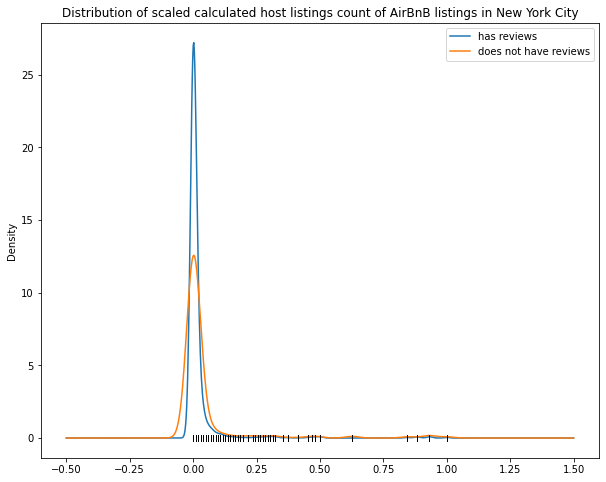

In [38]:
plot_distribution(eda_data_scaled, 'scaled_calculated_host_listings_count')

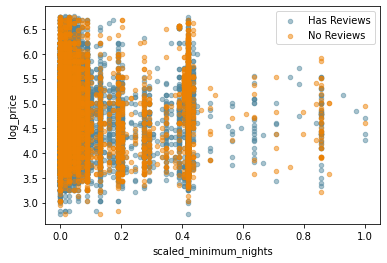

In [39]:
def plot_two_variables(df, var1, var2):
    ax = df[df['has_reviews']==1].plot(kind = 'scatter', x = var1, y = var2, 
                                  label = 'Has Reviews', color = '#50869D', 
                                  alpha = 0.5)
    df[df['has_reviews']==0].plot(kind = 'scatter',x = var1, y = var2, 
                                       label = 'No Reviews', color = '#ED8103',
                                       alpha = 0.5, ax=ax)
    ax.legend();
    
plot_two_variables(eda_data, 'scaled_minimum_nights',  'log_price')

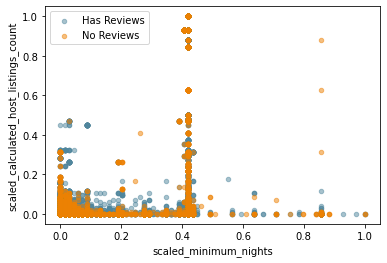

In [40]:
plot_two_variables(eda_data, 'scaled_minimum_nights', 'scaled_calculated_host_listings_count')

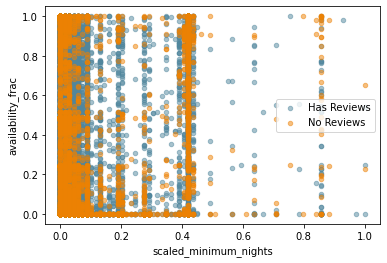

In [41]:
plot_two_variables(eda_data, 'scaled_minimum_nights', 'availability_frac')

sns.pairplot(eda_data[['has_reviews', 'log_price', 'availability_frac', 'room_type_entire_home/apt',
       'room_type_private_room', 'scaled_minimum_nights',
       'scaled_calculated_host_listings_count', 'scaled_longitude',
       'scaled_latitude']])

There are a number of measures that have not been taken that will be tested to see if they improve model accuracy after the first round of model training:
   
- downsampling listings with reviews

For now, all of the preprocessing steps above will be repeated on X_train and X_test (transformers will be fit only on X_test).
    

In [42]:
eda_data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews,log_price,availability_frac,room_type_entire_home/apt,room_type_private_room,scaled_minimum_nights,scaled_calculated_host_listings_count,scaled_longitude,scaled_latitude,scaled_price,scaled_log_price
0,Manhattan,East Village,40.72829,-73.98907,69.0,13.0,1.0,84.0,1.0,4.248495,0.230137,0.0,1.0,0.173913,0.000000,-0.940702,-0.031172,-0.644816,-0.724317
1,Brooklyn,Prospect Heights,40.68183,-73.97195,450.0,30.0,1.0,0.0,0.0,6.111467,0.000000,1.0,0.0,0.420290,0.000000,-0.472320,-0.895382,2.897036,2.158656
2,Manhattan,Midtown,40.74841,-73.98768,220.0,2.0,13.0,286.0,1.0,5.398163,0.783562,1.0,0.0,0.014493,0.117647,-0.902674,0.343083,0.758910,1.054808
3,Brooklyn,Bedford-Stuyvesant,40.69647,-73.94248,70.0,5.0,1.0,37.0,0.0,4.262680,0.101370,0.0,1.0,0.057971,0.000000,0.333943,-0.623061,-0.635520,-0.702366
4,Brooklyn,Brighton Beach,40.57974,-73.95892,55.0,1.0,1.0,0.0,1.0,4.025352,0.000000,0.0,1.0,0.000000,0.000000,-0.115835,-2.794375,-0.774963,-1.069635


## Apply preprocessing steps to train and test datasets

In [43]:
def convert_availability_column(df):
    new_df = df.copy()
    new_df['availability_frac'] = new_df['availability_365'] / 365
    new_df.drop(columns = ['availability_365'], inplace = True)
    return new_df

def apply_transformations(df,
                          one_hot_encoder, 
                          minmax_scaler, 
                          standard_scaler, 
                          fit = False):
    new_df = convert_availability_column(df)
    log_df = transform_log_normal_variables(new_df, ['price'], drop = True)
    ohe_df = one_hot_encode(log_df, 'room_type', one_hot_encoder, col_to_drop = 'Shared room', fit = fit)
    minmax_scaled_df = scale_data(ohe_df, ['minimum_nights', 'calculated_host_listings_count'], 
                                  minmax_scaler, drop = True, fit = fit)
    standard_scaled_df = scale_data(minmax_scaled_df, ['longitude', 'latitude', 'log_price'],
                                   standard_scaler, drop = True, fit = fit)
    return standard_scaled_df

one_hot_encoder = OneHotEncoder()
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
outlier_remover = OutlierRemover()

proc_train = apply_transformations(raw_train,
                                   one_hot_encoder,
                                   minmax_scaler,
                                   standard_scaler,
                                   fit = True)
proc_test = apply_transformations(raw_test,
                                  one_hot_encoder,
                                  minmax_scaler,
                                  standard_scaler,
                                  fit = False)
proc_train.head()

,neighbourhood_group,neighbourhood,has_reviews,availability_frac,room_type_entire_home/apt,room_type_private_room,scaled_minimum_nights,scaled_calculated_host_listings_count,scaled_longitude,scaled_latitude,scaled_log_price
0,Manhattan,East Village,1,0.230137,0.0,1.0,0.009608,0.00000,-0.799778,-0.012851,-0.703416
1,Brooklyn,Prospect Heights,0,0.000000,1.0,0.0,0.023219,0.00000,-0.428537,-0.864936,1.970820
2,Manhattan,Midtown,1,0.783562,1.0,0.0,0.000801,0.03681,-0.769637,0.356153,0.946894
3,Brooklyn,Bedford-Stuyvesant,0,0.101370,0.0,1.0,0.003203,0.00000,0.210510,-0.596435,-0.683054
4,Brooklyn,Brighton Beach,1,0.000000,0.0,1.0,0.000000,0.00000,-0.145985,-2.737285,-1.023731


In [44]:
proc_train.describe()

,has_reviews,availability_frac,room_type_entire_home/apt,room_type_private_room,scaled_minimum_nights,scaled_calculated_host_listings_count,scaled_longitude,scaled_latitude,scaled_log_price
count,39604.000000,39604.000000,39604.000000,39604.000000,39604.000000,39604.000000,3.960400e+04,3.960400e+04,3.960400e+04
mean,0.793329,0.310579,0.519341,0.456469,0.004847,0.019194,-1.037274e-13,8.319638e-14,5.221053e-16
std,0.404923,0.361035,0.499632,0.498108,0.016879,0.102666,1.000013e+00,1.000013e+00,1.000013e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.336959e+00,-4.203582e+00,-6.801994e+00
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.714051e-01,-7.116577e-01,-7.034160e-01
50%,1.000000,0.126027,1.000000,0.000000,0.001601,0.000000,-7.616085e-02,-1.092286e-01,-8.094556e-02
75%,1.000000,0.621918,1.000000,1.000000,0.003203,0.003067,3.445218e-01,6.255707e-01,6.282021e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.186926e+00,3.375864e+00,6.419296e+00


## Feature Selection

For now, we will ignore the neighbourhoods and neighbourhood groups assuming that the longitude and latitude information is enough for listings in the same neighbourhood to be considered similar.

This leaves us with the following columns:

In [45]:
cols_to_drop = ['neighbourhood_group', 'neighbourhood']

# save for later
neighbourhood_info_tr = proc_train[cols_to_drop]
neighbourhood_info_ts = proc_test[cols_to_drop]

proc_train.drop(columns = cols_to_drop, inplace = True)
proc_test.drop(columns = cols_to_drop, inplace = True)
proc_train.columns

Index(['has_reviews', 'availability_frac', 'room_type_entire_home/apt',
       'room_type_private_room', 'scaled_minimum_nights',
       'scaled_calculated_host_listings_count', 'scaled_longitude',
       'scaled_latitude', 'scaled_log_price'],
      dtype='object')

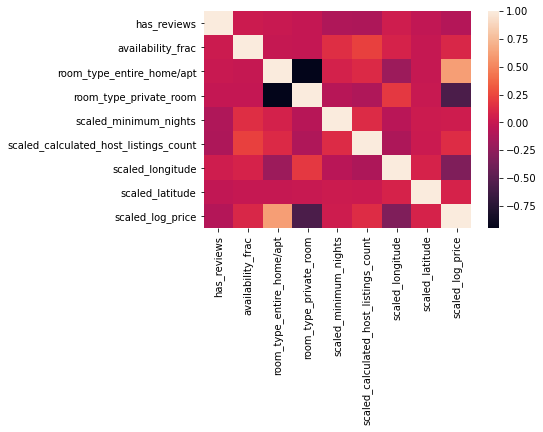

In [46]:
corrMatrix = proc_train.corr()
sns.heatmap(corrMatrix);

In [47]:
y_train = proc_train.pop('has_reviews')
X_train = proc_train.copy()

y_test = proc_test.pop('has_reviews')
X_test = proc_test.copy()

In [48]:
# Convert X_train, X_test, y_train, and y_test to numpy

X_train_np, X_test_np, y_train_np, y_test_np =  [df.to_numpy() for df in [X_train, X_test, y_train, y_test]]

y_train_np.shape

(39604,)

## Statistical Analysis

### Evaluation metric

How choose appropriate evaluation metric.

F1 score - balances precision and recall. Use f1 score of the *negative* class because it is more important to accurately identify poor performers than good performers.

We want to balance recall (catching as many of the real "no review" listings as possible) with precision (not calling out listings for not getting reviews when actually they will). 

### Model comparison

I'm gonna compare three model types: logistic regression and decision tree which are both relatively easy to explain using coefficient and leaf splits, and XGboost classifier which balances explainability with accuracy (CITE ME PLEASE).

To make the comparison the f1 score on the important (negative) class will be saved for comparison.

In [49]:
results_loc = 'model_comparison.csv'

with open(results_loc, 'w', newline = '') as f:
    writer = csv.writer(f)
    writer.writerow(['model_name', 'number_of_features', 'downsampled_data', 'outliers_removed', 'f1_negative_class', 'f1_macro_average'])

def calculate_f1s(y_pred, y_test):
    f1_negative_class = f1_score(y_test, y_pred, pos_label = 0)
    f1_macro_average = f1_score(y_test, y_pred, average = 'macro')
    return f1_negative_class, f1_macro_average   
    
def record_score(filename, model_name, num_features, downsampled, outliers_removed, y_pred, y_test):
    with open(filename, 'a', newline = '') as f:
        writer = csv.writer(f)
        row = [model_name, num_features]
        if downsampled:
            row.append('y')
        else:
            row.append('n')
        if outliers_removed:
            row.append('y')
        else:
            row.append('n')
        row += calculate_f1s(y_pred, y_test)
        writer.writerow(row)

## Logistic Regression


F1 scores for  Logistic Regression :

F1 score of negative class: 	 0.3842364532019705 
Macro average F1 score: 	 0.529272994709375


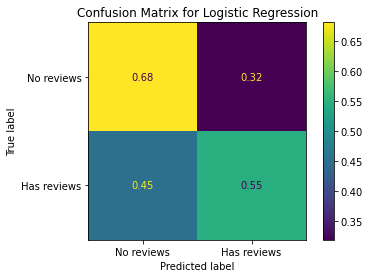

In [50]:
lr = LogisticRegression(C = 1, class_weight = 'balanced')

lr.fit(X_train_np, y_train_np)

target_names = ["No reviews", "Has reviews"]

def evaluate_model(model, X_test, y_test, model_name: str):
    y_pred = model.predict(X_test)
    f1_negative_class, f1_macro_average = calculate_f1s(y_pred, y_test)
    print("F1 scores for ", model_name, ":\n")
    print("F1 score of negative class: \t", f1_negative_class,
         "\nMacro average F1 score: \t", f1_macro_average)
    ax = plot_confusion_matrix(model, 
                      X_test, 
                      y_test, 
                      normalize = 'true', 
                      display_labels = target_names)
    plt.title("Confusion Matrix for " + model_name);
    return y_pred

y_pred = evaluate_model(lr, X_test_np, y_test_np, "Logistic Regression");

record_score(results_loc,
             "Logistic Regression", X_train_np.shape[1],
             False, False, y_pred, y_test)

In [51]:
classif_report = classification_report(y_test_np, y_pred, target_names=target_names)
print(classif_report)

              precision    recall  f1-score   support

  No reviews       0.27      0.68      0.38       858
 Has reviews       0.88      0.55      0.67      3543

    accuracy                           0.57      4401
   macro avg       0.57      0.61      0.53      4401
weighted avg       0.76      0.57      0.62      4401



## Decision Tree

F1 scores for  Decision Tree :

F1 score of negative class: 	 0.32847424684159376 
Macro average F1 score: 	 0.56177567620846


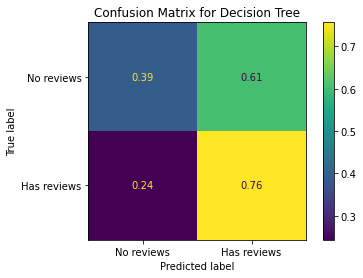

In [52]:
tree = DecisionTreeClassifier()

tree.fit(X_train_np, y_train_np)

y_pred = evaluate_model(DecisionTreeClassifier().fit(X_train_np, y_train_np), X_test_np, y_test_np, "Decision Tree")

record_score(results_loc,
             "Decision Tree", X_train_np.shape[1],
             False, False, y_pred, y_test)

It seems that the imbalance in class labels is causing the models to perform poorly. XGBoost has a `scale_pos_weight` parameter that may give it an advantage, but we can also try using `sklearn`'s `resample` to downsample the listings that have reviews, to see if it improves model performance. 

### Using XGBoost's `scale_pos_weight`

Using the scale_pos_weight parameter to adjust for imbalanced classes (see [this](https://machinelearningmastery.com/xgboost-for-imbalanced-classification/#:~:text=The%20XGBoost%20algorithm%20is%20effective,over%20the%20model%20training%20procedure.) blog post).


In [53]:
prop_no_reviews = sum(y_train==0)/sum(y_train==1)
prop_no_reviews

0.2605111556701359

F1 scores for  XGBoost :

F1 score of negative class: 	 0.42500831393415367 
Macro average F1 score: 	 0.5633238290982244


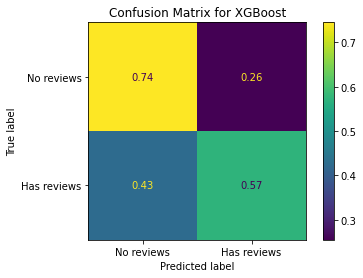

In [54]:
xgb_model = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', scale_pos_weight = prop_no_reviews, seed = 42)

xgb_model.fit(X_train_np, y_train_np)

y_pred = evaluate_model(xgb_model, X_test_np, y_test_np, "XGBoost")

record_score(results_loc,
             "XGBoost", X_train_np.shape[1],
             False, False, y_pred, y_test_np)

### Downsampling

In [55]:
# we will downsample only the training data.

def downsample(df: pd.DataFrame, target_col: str, majority_label: int) -> pd.DataFrame:
    minority_label = 1 if majority_label == 0 else 0
    # separate majority and minority class
    majority_class = df[df[target_col]== majority_label]
    minority_class = df[df[target_col]== minority_label]
    # count number of observations in minority class
    count_minority_class = len(minority_class.index)
    majority_class_downsampled = resample(majority_class, replace = False, n_samples = count_minority_class, random_state = 42)
    df_balanced = pd.concat([majority_class_downsampled, minority_class], axis = 0, sort = True)
    df_balanced.reset_index(drop=True)
    return df_balanced
    
# reattach target variable
proc_train['has_reviews'] = y_train

downsample_demo = proc_train.copy().reset_index()

train_ds = downsample(proc_train, 'has_reviews', 1)

print(train_ds["has_reviews"].value_counts())

y_train_ds = train_ds.pop('has_reviews')
X_train_ds = train_ds

1    8185
0    8185
Name: has_reviews, dtype: int64


In [56]:
# Make sure columns are still in same order
X_train_ds = X_train_ds[X_test.columns]
X_train_ds.columns

Index(['availability_frac', 'room_type_entire_home/apt',
       'room_type_private_room', 'scaled_minimum_nights',
       'scaled_calculated_host_listings_count', 'scaled_longitude',
       'scaled_latitude', 'scaled_log_price'],
      dtype='object')

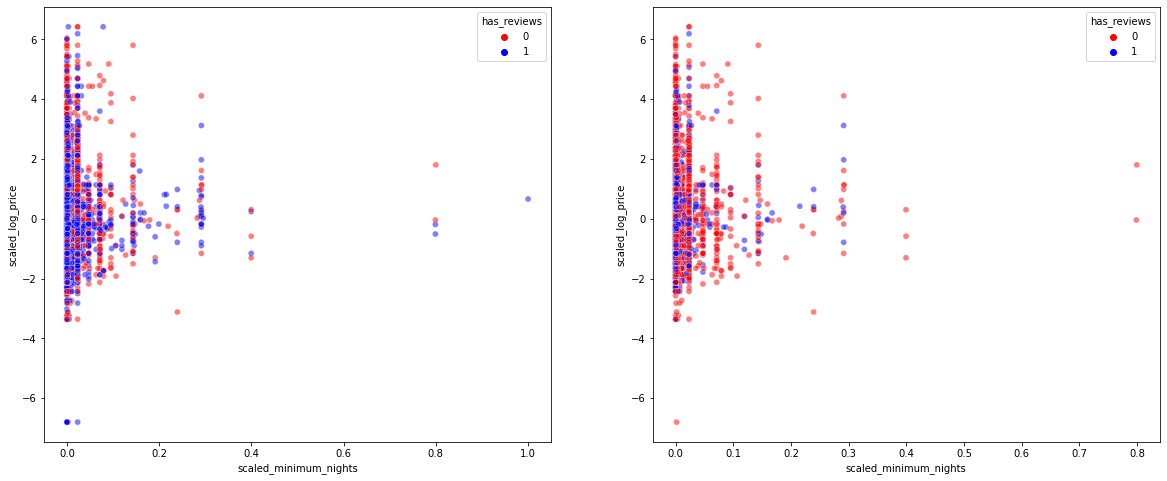

In [57]:
## visualise the downsampling

downsample_demo['in_downsampled_dataset'] = downsample_demo['index'].apply(lambda i: i in train_ds.index)
categories = [
    (downsample_demo['has_reviews']==1) & (downsample_demo['in_downsampled_dataset']),
    (downsample_demo['has_reviews']==0) & (downsample_demo['in_downsampled_dataset']),
    (~downsample_demo['in_downsampled_dataset'])
]
category_labels = [
    'Has reviews', 'No reviews', 'Removed from dataset'
]

downsample_demo['category'] = np.select(categories, category_labels)

palette = {
    1: 'blue', 
    0: 'red'
}

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20,8))
sns.scatterplot(data = downsample_demo,
                x = 'scaled_minimum_nights',
                y = 'scaled_log_price',
                hue = 'has_reviews',
                alpha = 0.5,
                palette = palette,
                ax = ax1)

sns.scatterplot(data = downsample_demo[downsample_demo['category']!='Removed from dataset'],
                x = 'scaled_minimum_nights',
                y = 'scaled_log_price',
                hue = 'has_reviews',
                alpha = 0.5,
                palette = palette,
                ax = ax2);

F1 scores for  Logistic Regression :

F1 score of negative class: 	 0.38024857238831045 
Macro average F1 score: 	 0.5317551874817088


,feature,coef
3,scaled_minimum_nights,-9.501772
4,scaled_calculated_host_listings_count,-2.730488
1,room_type_entire_home/apt,1.160919
0,availability_frac,0.693522
2,room_type_private_room,0.528415
7,scaled_log_price,-0.363912
6,scaled_latitude,-0.025208
5,scaled_longitude,-0.008062


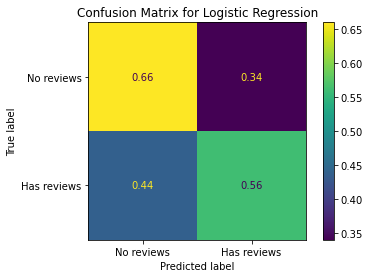

In [58]:
lr = LogisticRegression()

lr.fit(X_train_ds, y_train_ds)

y_pred = evaluate_model(lr, X_test, y_test, "Logistic Regression")

coefficients = pd.DataFrame(data = {
    'feature': X_train_ds.columns,
    'coef': lr.coef_[0],
    'coef_magnitude': [abs(c) for c in lr.coef_[0]]
})
coefficients.sort_values('coef_magnitude', ascending = False).drop(columns = ['coef_magnitude'])

In [59]:
print("Size of original dataset: ", len(X_train),
      "\nSize of downsampled dataset: ", len(X_train_ds),
     "\nSize of test dataset: ", len(X_test))

Size of original dataset:  39604 
Size of downsampled dataset:  16370 
Size of test dataset:  4401


,num_features,neg_class_f1
0,1,0.346269
1,2,0.328358
2,3,0.347728
3,4,0.350799
4,5,0.368987
5,6,0.366730
6,7,0.378933


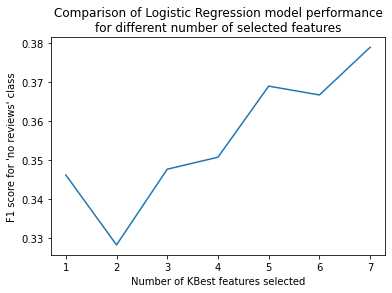

In [60]:
# Choose the best number of features

def feature_select(X_train, y_train, X_test, y_test, model, model_name):
    num_features = range(1,len(X_train.columns))
    f1_scores = []

    for num in num_features:
        kbest = SelectKBest(score_func = f_classif, k = num)
        kbest.fit(X=X_train, y = y_train)

        selected_columns = X_train.columns[kbest.get_support()]

        model.fit(X_train[selected_columns], y_train)
        y_pred = model.predict(X_test[selected_columns])

        # look specifically at the F1 score of the 'no reviews' class
        f1 = f1_score(y_test, y_pred, pos_label = 0)
        #print("Number of features: ", num, "\t\tNegative class F1 score: ", f1)
        f1_scores.append(f1)
    ax = plt.plot(num_features, f1_scores)
    plt.ylabel("F1 score for 'no reviews' class")
    plt.xlabel("Number of KBest features selected")
    plt.title(f"Comparison of {model_name} model performance\nfor different number of selected features")
    return pd.DataFrame(data = {'num_features': num_features, 'neg_class_f1': f1_scores})
    
feature_select(X_train_ds, y_train_ds, X_test, y_test, LogisticRegression(), "Logistic Regression")

The model actually appears to perform the best with all of the features.

In [61]:
def get_coefficients(X_test, model):
    coefs = model.coef_[0]
    coefficients = pd.DataFrame(data = {
            'feature': X_test.columns,
            'coef': coefs,
            'coef_magnitude': [abs(c) for c in coefs]
        })

    return coefficients.sort_values('coef_magnitude', ascending = False).drop(columns = ['coef_magnitude'])

get_coefficients(X_test, lr)

,feature,coef
3,scaled_minimum_nights,-9.501772
4,scaled_calculated_host_listings_count,-2.730488
1,room_type_entire_home/apt,1.160919
0,availability_frac,0.693522
2,room_type_private_room,0.528415
7,scaled_log_price,-0.363912
6,scaled_latitude,-0.025208
5,scaled_longitude,-0.008062


Let's test our new downsampled dataset with a decision tree.

#### Decision Tree

F1 scores for  Decision Tree :

F1 score of negative class: 	 0.35025706940874035 
Macro average F1 score: 	 0.49744839410683067


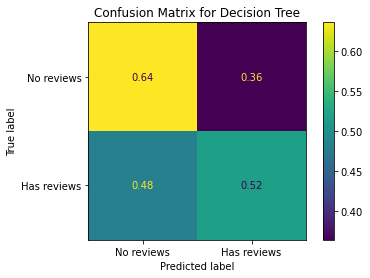

In [62]:
tree = DecisionTreeClassifier()

tree.fit(X_train_ds, y_train_ds)

y_pred = evaluate_model(tree, X_test, y_test, "Decision Tree")

record_score(results_loc,
             "Decision Tree", X_train_ds.shape[1],
             True, False, y_pred, y_test)

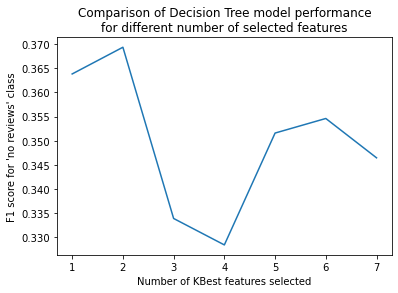

In [63]:
feature_select(X_train_ds, y_train_ds, X_test, y_test, tree, "Decision Tree");

F1 scores for  Decision Tree :

F1 score of negative class: 	 0.3529790660225443 
Macro average F1 score: 	 0.5001686623776054


'Selected features: availability_frac, scaled_minimum_nights, scaled_calculated_host_listings_count, scaled_longitude, scaled_latitude, scaled_log_price'

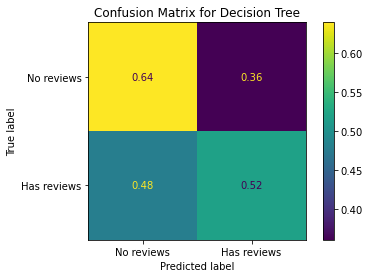

In [64]:
def get_selected_columns(X_train, y_train, k):
    kbest = SelectKBest(score_func = f_classif, k = k)
    kbest.fit(X=X_train, y = y_train)
    cols = kbest.get_support()
    selected_cols = X_train.columns[cols]
    return selected_cols

selected_features = get_selected_columns(X_train_ds, y_train_ds, 6)

tree.fit(X_train_ds[selected_features], y_train_ds)

y_pred = evaluate_model(tree, X_test[selected_features], y_test, "Decision Tree")

record_score(results_loc,
             "Decision Tree", len(selected_features),
             True, False, y_pred, y_test)

'Selected features: ' + ', '.join(selected_features)

#### XGBoost

F1 scores for  XGBoost :

F1 score of negative class: 	 0.4132795532112939 
Macro average F1 score: 	 0.5371649603303288


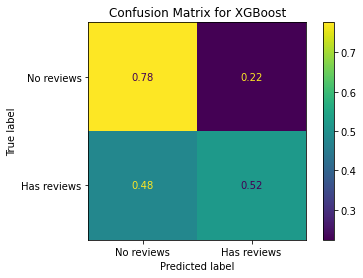

In [65]:
xgb_model = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', seed = 42)

xgb_model.fit(X_train_ds, y_train_ds)

y_pred = evaluate_model(xgb_model, X_test, y_test, "XGBoost")

record_score(results_loc,
             "XGBoost", X_train_ds.shape[1],
             True, False, y_pred, y_test)

,num_features,neg_class_f1
0,1,0.363794
1,2,0.373421
2,3,0.367730
3,4,0.374463
4,5,0.403738
5,6,0.413922
6,7,0.414029


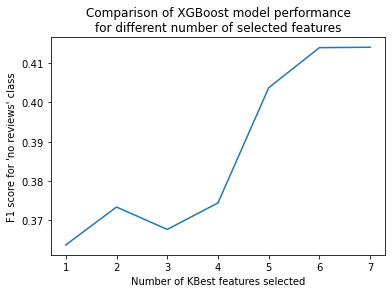

In [66]:
feature_select(X_train_ds, y_train_ds, X_test, y_test, xgb_model, "XGBoost")

### Re-testing with outlier removal

In [67]:
X_train

,availability_frac,room_type_entire_home/apt,room_type_private_room,scaled_minimum_nights,scaled_calculated_host_listings_count,scaled_longitude,scaled_latitude,scaled_log_price
0,0.230137,0.0,1.0,0.009608,0.000000,-0.799778,-0.012851,-0.703416
1,0.000000,1.0,0.0,0.023219,0.000000,-0.428537,-0.864936,1.970820
2,0.783562,1.0,0.0,0.000801,0.036810,-0.769637,0.356153,0.946894
3,0.101370,0.0,1.0,0.003203,0.000000,0.210510,-0.596435,-0.683054
4,0.000000,0.0,1.0,0.000000,0.000000,-0.145985,-2.737285,-1.023731
...,...,...,...,...,...,...,...,...
39599,0.000000,0.0,1.0,0.000801,0.000000,0.075415,0.994942,-0.326801
39600,0.649315,0.0,1.0,0.001601,0.021472,0.516915,2.469492,-0.326801
39601,0.772603,0.0,1.0,0.000000,0.000000,0.383554,0.152577,-1.369912
39602,0.000000,0.0,1.0,0.000000,0.000000,0.500001,-0.840727,-1.157985


In [68]:
X_train_ds

,availability_frac,room_type_entire_home/apt,room_type_private_room,scaled_minimum_nights,scaled_calculated_host_listings_count,scaled_longitude,scaled_latitude,scaled_log_price
17896,0.000000,0.0,1.0,0.000801,0.000000,0.575464,-0.913721,-1.102768
6587,0.852055,0.0,1.0,0.000801,0.003067,1.544551,0.284260,-1.186411
13191,0.208219,0.0,1.0,0.001601,0.012270,-0.037562,-1.397718,-1.306103
17107,0.000000,1.0,0.0,0.003203,0.003067,-0.645383,-1.012941,-0.683054
28868,0.087671,1.0,0.0,0.000801,0.000000,-1.026817,0.467845,-0.177137
...,...,...,...,...,...,...,...,...
39579,0.000000,0.0,1.0,0.000801,0.000000,-0.242265,-0.279701,-0.724071
39580,0.084932,0.0,1.0,0.000000,0.000000,-1.265999,-1.513995,-1.245010
39584,0.000000,0.0,1.0,0.001601,0.000000,-0.961980,-0.199921,0.810729
39590,0.997260,1.0,0.0,0.023219,0.147239,-0.781563,0.061610,1.317000


In [69]:
numeric_columns = X_train.select_dtypes('number').columns

# fit the outlier remover to the full (not downsampled) training set

o_r = OutlierRemover()
o_r.fit(proc_train[numeric_columns])

X_train_ds_ol = pd.concat([X_train_ds, y_train_ds], axis = 1)
X_train_ol = pd.concat([X_train, y_train], axis = 1)

# Separate target variable in test dataset
X_train_ds_ol = o_r.transform(X_train_ds_ol)
X_train_ol = o_r.transform(X_train_ol)

y_train_ds_ol = X_train_ds_ol.pop('has_reviews')
y_train_ol = X_train_ol.pop('has_reviews')

print("Size of original dataset: ", len(X_train),
      "\nSize of dataset without outliers: ", len(X_train_ol),
      "\nSize of downsampled dataset: ", len(X_train_ds),
      "\nSize of downsampled dataset without outliers: ", len(X_train_ds_ol),
     "\n\nSize of test dataset: ", len(X_test),
     "\n\nProportion of listings with reviews in downsampled training dataset: ", len(y_train_ds_ol[y_train_ds_ol==1])/len(y_train_ds_ol[y_train_ds_ol==0]),
     "\n\nProportion of listings with reviews in training dataset: ", len(y_train_ol[y_train_ol==1])/len(y_train_ol[y_train_ol==0]),)

Size of original dataset:  39604 
Size of dataset without outliers:  37448 
Size of downsampled dataset:  16370 
Size of downsampled dataset without outliers:  15252 

Size of test dataset:  4401 

Proportion of listings with reviews in downsampled training dataset:  1.0596893990546927 

Proportion of listings with reviews in training dataset:  4.057123565158677


In [70]:
downsampled = False

for model, model_name in zip([lr, tree, xgb_model], ['Logistic Regression', 'Decision Tree', 'XGBoost']):
    for training_set in [(X_train_ol, y_train_ol), (X_train_ds_ol, y_train_ds_ol)]:
        model.fit(training_set[0], training_set[1])
        y_pred = model.predict(X_test)
        record_score(results_loc,
                 model_name, training_set[0].shape[1],
                 downsampled, True, y_pred, y_test)
        downsampled = not downsampled

In [71]:
all_models = pd.read_csv(results_loc).drop_duplicates() # in case cell was run twice
all_models.sort_values('f1_negative_class', ascending = False)

,model_name,number_of_features,downsampled_data,outliers_removed,f1_negative_class,f1_macro_average
2,XGBoost,8,n,n,0.425008,0.563324
5,XGBoost,8,y,n,0.413280,0.537165
11,XGBoost,8,y,y,0.404365,0.523644
0,Logistic Regression,8,n,n,0.384236,0.529273
7,Logistic Regression,8,y,y,0.373082,0.535041
9,Decision Tree,8,y,y,0.354173,0.497030
4,Decision Tree,6,y,n,0.352979,0.500169
3,Decision Tree,8,y,n,0.350257,0.497448
10,XGBoost,8,n,y,0.334315,0.606438
1,Decision Tree,8,n,n,0.328474,0.561776


SOME INTERPRETATION HERE

The outliers comprise around 5% of the data so you would expect performance on data that includes outliers to be 5% worse if outlier removal prevents learning.

AND NOTE: Downsampled data is an entirely different dataset.

### Model Selection

By far the best-performing model was the XGBoost, particularly when the full dataset was used. 

F1 scores for  XGBoost :

F1 score of negative class: 	 0.42500831393415367 
Macro average F1 score: 	 0.5633238290982244


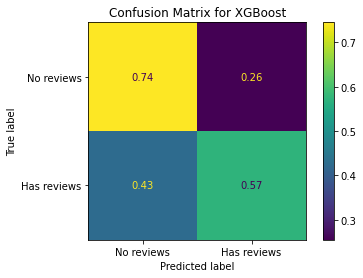

In [76]:
xgb_model = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', scale_pos_weight = prop_no_reviews, seed = 42)

xgb_model.fit(X_train_np, y_train_np)

y_pred = evaluate_model(xgb_model, X_test_np, y_test_np, "XGBoost");


This model performs much better than all of the previous models, so will be selected for further tuning. The coefficients of the logistic regression model will also be examined, to understand what factors contributed to the predictions.

## Model Tuning

To tune the model we will evaluate it against the final test set.

In [88]:
# Fit the transformers to the training dataset
apply_transformations(raw_train.drop(['has_reviews'], axis = 1), 
                      one_hot_encoder, 
                      minmax_scaler, 
                      standard_scaler, 
                      fit = True)

final_test_set_ = encode_target(final_test_set)
y_test_final = final_test_set_.pop('has_reviews')
final_test_set_.drop(['neighbourhood', 'neighbourhood_group'], axis = 1, inplace = True)

X_test_final = apply_transformations(
    final_test_set_, one_hot_encoder, minmax_scaler, standard_scaler, fit = False
)

X_test_final.shape

(4890, 8)

F1 scores for  Optimised XGBoost Model :

F1 score of negative class: 	 0.4354053279862503 
Macro average F1 score: 	 0.5610004855863833


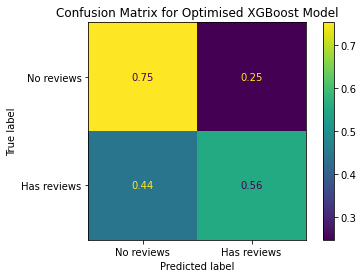

In [89]:
params = {
    'max_depth': [2,4,6,8],
    'learning_rate': [0.1,0.2,0.4,0.8],
    'objective': ['reg:squarederror', 'binary:logistic']
}

from sklearn.model_selection import GridSearchCV

custom_scorer = make_scorer(f1_score, pos_label = 0)

xgb_optimised = GridSearchCV(xgb_model, params, scoring = custom_scorer).fit(X_train, y_train)

y_pred = evaluate_model(xgb_optimised, X_test_final, y_test_final, "Optimised XGBoost Model")

In [90]:
xgb_optimised.best_params_

{'learning_rate': 0.2, 'max_depth': 4, 'objective': 'reg:squarederror'}

In [155]:
# fit the model to the whole dataset to maximise performance.

all_data = pd.concat([airbnb, final_test_set], axis = 0)
all_data = encode_target(all_data)
all_data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
18853,Brooklyn,Windsor Terrace,40.65949,-73.98422,Private room,90,2,3,2,0
5011,Manhattan,Nolita,40.72061,-73.99472,Private room,80,6,3,1,0
34244,Brooklyn,Fort Greene,40.68876,-73.97048,Entire home/apt,1200,3,1,1,0
25590,Manhattan,Hell's Kitchen,40.76093,-73.99103,Private room,120,1,112,2,76
42735,Bronx,Pelham Bay,40.84342,-73.83929,Entire home/apt,125,1,15,1,336


In [ ]:
model = XGBClassifier(use_label_encoder = False, 
              eval_metric = 'logloss', 
              scale_pos_weight = prop_no_reviews, 
              seed = 42,
              learning_rate = 0.2,
              max_depth = 4,
              objective = 'reg:squarederror')

### Feature Importance



Something something select K Best. Also let's look at the coefficients of the logistic regression model.

In [91]:
get_selected_columns(X_train, y_train, 4) # no downsampling or outlier removal

Index(['scaled_minimum_nights', 'scaled_calculated_host_listings_count',
       'scaled_longitude', 'scaled_log_price'],
      dtype='object')

In [92]:
get_selected_columns(X_train_ds_ol, y_train_ds_ol, 4) # downsampling and outlier removal

Index(['availability_frac', 'scaled_minimum_nights',
       'scaled_calculated_host_listings_count', 'scaled_log_price'],
      dtype='object')

In [93]:
get_selected_columns(X_train_ol, y_train_ol, 4) # no downsampling but outlier removal

Index(['availability_frac', 'scaled_minimum_nights',
       'scaled_calculated_host_listings_count', 'scaled_log_price'],
      dtype='object')

In [94]:
lr.fit(X_train, y_train)
lr_coefs = get_coefficients(X_test, lr)
lr_coefs

,feature,coef
3,scaled_minimum_nights,-11.164310
4,scaled_calculated_host_listings_count,-2.282715
1,room_type_entire_home/apt,1.202075
0,availability_frac,0.638012
2,room_type_private_room,0.576829
7,scaled_log_price,-0.389935
6,scaled_latitude,-0.026978
5,scaled_longitude,-0.011130


In [154]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer()
shap_values = explainer.shap_values(X_train)

Exception: Model type not yet supported by TreeExplainer: <class 'sklearn.model_selection._search.GridSearchCV'>

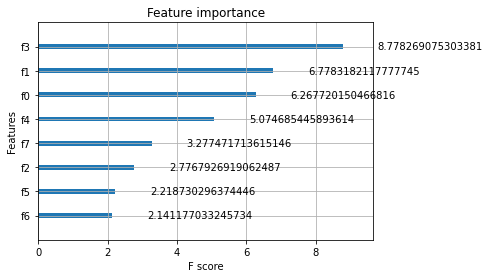

In [95]:
plot_importance(xgb_model, importance_type = 'gain');

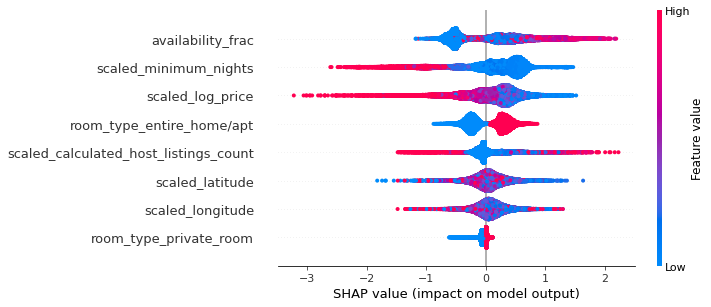

In [96]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(X_train) 
shap.summary_plot(shap_values, X_train)

### Exploring Results


In [145]:
results_scaled = X_test_final.copy().reset_index(drop = True)

results_scaled['y'] = y_test_final.reset_index(drop = True)

results_scaled['y_pred'] = y_pred

results_scaled.head()

,availability_frac,room_type_entire_home/apt,room_type_private_room,scaled_minimum_nights,scaled_calculated_host_listings_count,scaled_longitude,scaled_latitude,scaled_log_price,y,y_pred
0,0.517808,1.0,0.0,0.004175,0.0,-0.572894,-1.543586,-0.312472,1,1
1,0.200000,0.0,1.0,0.041754,0.0,0.946811,-0.392631,-1.859721,0,0
2,0.000000,0.0,1.0,0.002088,0.0,-0.841959,0.601143,0.117202,1,0
3,0.745205,1.0,0.0,0.002088,1.0,-1.283668,-0.374944,2.090154,1,1
4,0.082192,1.0,0.0,0.002088,0.0,0.402167,1.247005,0.846718,1,1


In [147]:
results_scaled.isna().sum()

availability_frac                        0
room_type_entire_home/apt                0
room_type_private_room                   0
scaled_minimum_nights                    0
scaled_calculated_host_listings_count    0
scaled_longitude                         0
scaled_latitude                          0
scaled_log_price                         0
y                                        0
y_pred                                   0
dtype: int64

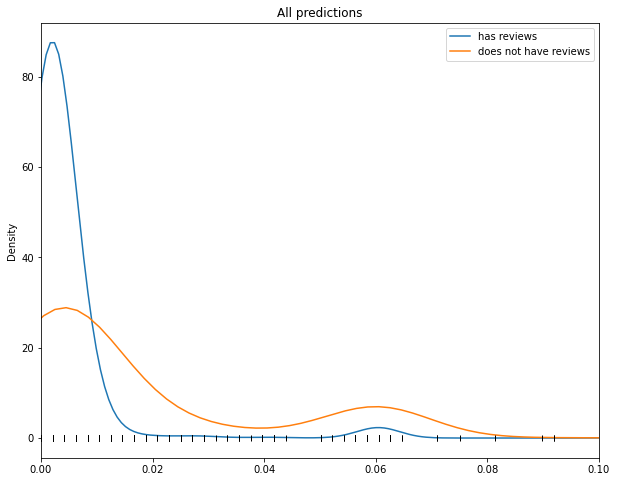

In [148]:
ax = plot_distribution(results_scaled, 'scaled_minimum_nights', color_split = 'y_pred', title = 'All predictions')
ax.set_xlim(left = 0, right = 0.1);

In [149]:
# group the availability fractions into bins
results_scaled['availability_cat'] = results_scaled['availability_frac'].apply(lambda x: math.floor((x*100)/10)/10)

# calculate the f1_score for each bin
f1_scores = {}
prop = {}
for cat in [round(x,1) for x in np.linspace(0.0, 0.9, 10)]:
    sample = results_scaled[results_scaled['availability_cat']==cat]
    f1_scores[cat] = f1_score(sample['y'], sample['y_pred'], average = 'macro')
    prop[cat] = len(sample[sample['y']==0])
for cat, f1 in f1_scores.items():
    print(f"{cat}: {f1}")

print()
for cat, p in prop.items():
    print(cat, ': ', p)

0.0: 0.4614913881195225
0.1: 0.5927230046948357
0.2: 0.6543052975744343
0.3: 0.6442640692640693
0.4: 0.5890470974808324
0.5: 0.6538825757575757
0.6: 0.6718176254589963
0.7: 0.6595048086760794
0.8: 0.5913461538461539
0.9: 0.6507391708880388

0.0 :  569
0.1 :  47
0.2 :  76
0.3 :  24
0.4 :  40
0.5 :  25
0.6 :  33
0.7 :  13
0.8 :  47
0.9 :  94


In [150]:
print(len(airbnb))
print(len(final_test_set))
airbnb = pd.concat([airbnb, final_test_set], axis = 0)
print(len(airbnb))

48895
4890
53785


In [151]:
# inspect the original (unscaled/unencoded) dataframe also
results = airbnb.copy()
results = encode_target(results)


all_reviews = results['has_reviews']

#

processed_airbnb = apply_transformations(results, 
                                         one_hot_encoder, 
                                         minmax_scaler, 
                                         standard_scaler, 
                                         fit = False
                                        )

y_pred_all = xgb_optimised.predict(processed_airbnb.iloc[:, 3:])

results['prediction'] = y_pred_all

room_type_results = {}
room_type_count = {}
room_type_prop = {}

for room_type in results['room_type'].unique():
    temp = results[results['room_type']==room_type]
    room_type_count[room_type] = len(temp)
    room_type_results[room_type] = f1_score(temp['has_reviews'], temp['prediction'], pos_label = 0)
    room_type_prop[room_type] = len(temp[temp['has_reviews']==0])/len(temp)
for room_type, score in room_type_results.items():
    print(f'{room_type}\n Count: {room_type_count[room_type]}\tProportion without reviews: {room_type_prop[room_type]: .3f} \t0-class F1 score: {score: .3f}')

Private room
 Count: 24581	Proportion without reviews:  0.209 	0-class F1 score:  0.497
Entire home/apt
 Count: 27931	Proportion without reviews:  0.199 	0-class F1 score:  0.489
Shared room
 Count: 1273	Proportion without reviews:  0.269 	0-class F1 score:  0.565


In [152]:
processed_airbnb.head(1)

,neighbourhood_group,neighbourhood,has_reviews,availability_frac,room_type_entire_home/apt,room_type_private_room,scaled_minimum_nights,scaled_calculated_host_listings_count,scaled_longitude,scaled_latitude,scaled_log_price
0,Brooklyn,Windsor Terrace,1,0.0,0.0,1.0,0.000801,0.003067,-0.696066,-1.27185,-0.322463


In [ ]:
processed_airbnb

In [ ]:
airbnb.columns

In [ ]:
plt.scatter(x = results[''])

In [ ]:
len(re)